# NBA Game Predictor
---

**Purpose:** Predict the outcome of NBA games using the Four Factors (calculated from the game boxscores) and homecourt advantage

In [1]:
# Imports
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import pickle as pk

## Wrangle Data

For this model, I will be using the 'Four Factors' as coined by Dean Oliver: Effective Shooting %, Turnover Rate, Defensive Rebounding Rate, and Free Throw Rate. These numbers use most of the traditional box score numbers to calculate four figures (per team) that are in the form of rates and offer fairer comparisons than the raw counting stats. 

Before calculating these new metrics, I will also need to create a Defensive Rebounds feature (DefRebound) in order to calculate the Rebounding Rate.

The WINorLOSS and Home features also need to be converted to 1s and 0s for a Logistic Regression model.

In [ ]:
pd.read_csv('data/nba.games.stats.csv', parse_dates=['Date'], index_col='Date').columns

In [3]:
def wrangle_fourfactors(filepath):
    """Wrangle data"""
    df = pd.read_csv(filepath,
                     parse_dates=['Date'],
                     index_col='Date')
    
    # Drop leaky columns and extraneous 'unnamed' column
    drop_cols = ['TeamPoints', 'OpponentPoints', 'Unnamed: 0']
    df.drop(columns=drop_cols, inplace=True)
    
    # Transform WINorLOSS to binary values, rename to Win
    df['WINorLOSS'] = df['WINorLOSS'].map({'W':1, 'L':0})
    df.rename(columns={'WINorLOSS':'win'}, inplace=True)
    
    # Transform Home to binary value
    df['Home'] = df['Home'].map({'Home':1,'Away':0})
    
    # Create Defensive Rebounds feature
    df['DefRebound'] = df['TotalRebounds'] - df['OffRebounds']
    df['Opp.DefRebound'] = df['Opp.TotalRebounds'] - df['Opp.OffRebounds']
    
    ##########################################
    ## Create features for the 'Four Factors' 
    
    # Shooting : (FG + 0.5 * 3FG) / FGA
    df['h_efg'] = (df['FieldGoals'] + 0.5 * df['X3PointShots']) / df['FieldGoalsAttempted']
    df['a_efg'] = (df['Opp.FieldGoals'] + 0.5 * df['Opp.3PointShots']) / df['Opp.FieldGoalsAttempted']
    
    # Turnovers : TOV / (FGA + 0.44 * FTA + TOV)
    df['h_tov'] = df['Turnovers'] / (df['FieldGoalsAttempted'] + 0.44 * df['FreeThrowsAttempted'] + df['Turnovers'])
    df['a_tov'] = df['Opp.Turnovers'] / (df['Opp.FieldGoalsAttempted'] + 0.44 * df['Opp.FreeThrowsAttempted'] + df['Opp.Turnovers'])
    
    # Rebounding : DRB / (Opp ORB + DRB)
    df['h_drb'] = df['DefRebound'] / (df['Opp.OffRebounds'] + df['DefRebound'])
    df['a_drb'] = df['Opp.DefRebound'] / (df['OffRebounds'] + df['Opp.DefRebound'])
    
    # Freethrows : FT / FGA
    df['h_ftr'] = df['FreeThrows'] / df['FieldGoalsAttempted']
    df['a_ftr'] = df['Opp.FreeThrows'] / df['Opp.FieldGoalsAttempted']
    
    ##########################################
    
    return df[['h_efg', 'a_efg', 'h_tov', 'a_tov', 'h_drb', 'a_drb', 'h_ftr', 'a_ftr', 'win']]

df = wrangle_fourfactors('data/nba.games.stats.csv')

In [4]:
# Check our wrangled data
print(df.shape)
df.head()

(9840, 9)


,h_efg,a_efg,h_tov,a_tov,h_drb,a_drb,h_ftr,a_ftr,win
Date,,,,,,,,,
2014-10-29,0.581250,0.455556,0.162711,0.079281,0.666667,0.761905,0.112500,0.300000,0
2014-11-01,0.557971,0.456790,0.125628,0.166297,0.755556,0.916667,0.362319,0.222222,1
2014-11-05,0.456522,0.485507,0.118354,0.181436,0.710526,0.795918,0.086957,0.391304,0
2014-11-07,0.532258,0.525773,0.153921,0.148577,0.738095,0.851064,0.215054,0.206186,0
2014-11-08,0.462963,0.523810,0.076307,0.144453,0.690476,0.720930,0.345679,0.095238,1


## Split Data

Here I will specify my target feature as the win column, and split the dataset into 

I will use a time-based split for the train-validation-test groups. The first 2 seasons will be training, the 3rd validation, and the 4th will be the test group.

In [5]:
# Split Data
target = 'win'
X = df.drop(columns=target)
y = df[target]

# Train-Val-Test Split
train_cutoff = slice("2014-10-28","2016-04-13")
X_train, y_train = X.loc[train_cutoff], y.loc[train_cutoff]

val_cutoff = slice("2016-10-25","2017-04-12")
X_val, y_val = X.loc[val_cutoff], y.loc[val_cutoff]

test_cutoff = slice("2017-10-17","2018-04-11")
X_test, y_test = X.loc[test_cutoff], y.loc[test_cutoff]

## Build Models

Build basic models of the following types:

- LogisticRegressionClassifier
- RidgeClassifier
- RandomForestClassifier
- GradientBoostedClassifier

Compare performance of each model against the calculated baseline accuracy.

### Model Pipelines

In [6]:
# Build LogisticRegressionClassifier model
model_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42)
)

model_lr.fit(X_train, y_train);

In [7]:
# Build RidgeClassifier model
model_rc = make_pipeline(
    StandardScaler(),
    RidgeClassifier(random_state=42)
)
model_rc.fit(X_train, y_train);

In [9]:
# Build RandomForestClassifier model
model_rf = make_pipeline(
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
model_rf.fit(X_train, y_train);

In [8]:
# Build XGBoosted model
model_gb = make_pipeline(
    XGBClassifier(learning_rate=0.1)
)
model_gb.fit(X_train, y_train);

### Model Accuracies

In [10]:
# Compare accuracies of baseline and initial models
print("Model\t\t\t Accuracy")
print("Baseline:\t\t", y_train.value_counts(normalize=True).max())
print('Logistic Regression:\t', model_lr.score(X_val, y_val))
print('Ridge Classifier:\t', model_rc.score(X_val, y_val))
print('Random Forest:\t\t', model_rf.score(X_val, y_val))
print('Gradient Boosting:\t', model_gb.score(X_val, y_val))

Model			 Accuracy
Baseline:		 0.5
Logistic Regression:	 0.9520325203252032
Ridge Classifier:	 0.9479674796747968
Random Forest:		 0.9044715447154471
Gradient Boosting:	 0.9146341463414634


### Select Model

In [11]:
# Select model
m = 'lr'
if m == 'lr':
    model, estimator = model_lr, 'logisticregression'
    t = 'reg'
elif m == 'rc':
    model, estimator = model_rc, 'ridgeclassifier'
    t = 'reg'
elif m == 'rf':
    model, estimator = model_rf, 'randomforestclassifier'
    t = 'tree'
elif m == 'xgb':
    model, estimator = model_gb, 'xgbclassifier'
    t = 'tree'


### Save Model

In [109]:
# save model
with open('predictor_app/model.pickle', 'wb') as f:
    pk.dump(model, f, protocol=pk.HIGHEST_PROTOCOL)

## Communicate Results

### Feature Importances

Text(0, 0.5, 'Feature')

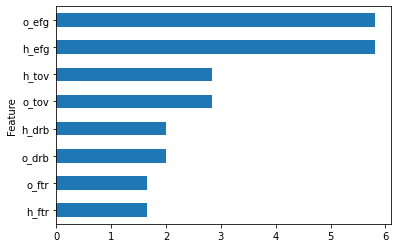

In [153]:
# Feature Importance
if t == 'reg':
    importance = model.named_steps[estimator].coef_[0]
elif t == 'tree':
    importance = model.named_steps[estimator].feature_importances_
features_names = X_train.columns
pd.Series(data=importance, index=features_names).abs().sort_values().tail(10).plot(kind='barh')
plt.ylabel('Feature')

### Permutation Importances

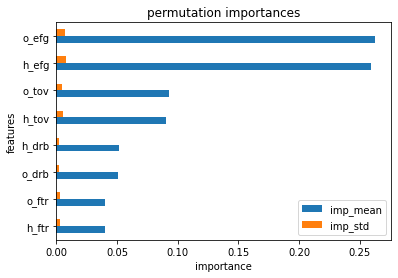

In [150]:
# Permutation Importance
perm_imp = permutation_importance(model,X_val,y_val,random_state=42)
data_perm = {'imp_mean':perm_imp['importance_mean'],
             'imp_std':perm_imp['importance_std']}

df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
df_perm.tail(10).plot(kind='barh')
plt.title('permutation importance')
plt.ylabel('features')
plt.xlabel('importance');